In [1]:
#| code-fold: true
#| code-summary: Load Sprouse et al.'s Experiments 1 and 3

import os
from pandas import DataFrame, read_csv, concat

def load_data(fname: str, remove_fillers: bool = False) -> DataFrame:
    """Load Sprouse et al.'s (2016) data
    
    Parameters
    ----------
    fname
        The filename of the data
    remove_fillers
        Whether to remove the fillers
    
    Returns
    -------
    data
        The data
    """
    # read the raw data skipping comment rows at the beginning
    data = read_csv(fname, skiprows=5)
    
    # remove NaN judgments
    data = data.query("~judgment.isnull()")
    
    # fill NaNs
    for col in ["dependency", "structure", "distance", "island"]:
        data.loc[:,col] = data[col].fillna("filler")
    
    # remove fillers
    if remove_fillers:
        data = data.query("dependency != 'filler'")
    
    return data

data_dir = "./data/SCGC.data/"

data_exp1_test = load_data(
    os.path.join(data_dir, "Experiment 1 results - English.csv"),
    remove_fillers=True
)
data_exp3_test = load_data(
    os.path.join(data_dir, "Experiment 3 results - English D-linking.csv"),
    remove_fillers=True
)

data_exp3_test["dependency"] = data_exp3_test.dependency.map({
    "WH": "DlinkedWH", "RC": "DlinkedRC", "filler": "filler"
})

data_exp1_test["exp"] = 1
data_exp3_test["exp"] = 3

data_test = concat([data_exp1_test, data_exp3_test])

In [2]:
#| code-fold: true
#| code-summary: Silence STAN logger

import logging
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

We will fit our model families using Markov chain Monte Carlo (MCMC) as implemented in STAN. As I mentioned in the last section, you can find a very brief introduction to MCMC in STAN [here](../foundational-concepts-in-probability-and-statistics/statistical-inference.ipynb#implementing-samplers-in-stan) in the course notes on [statistical inference](../foundational-concepts-in-probability-and-statistics/statistical inference). 

To compare our model families, we want to quantitatively measure the fit of those theories' best analyses to the data (identified by a particular parameterization) and–as a measure of parsimony–weight that fit against how many such best analyses there are. The more constrained the family of theories, the fewer such best analyses it will have and thus the more parsimonious we will consider it. A common way to implement this comparison is using an [information criterion](https://en.wikipedia.org/wiki/Model_selection#Criteria). 

Most information criteria attempt to estimate (a family of) models' performance on data it was not fit to [@gelman_understanding_2014]. They have have two components: a measure of the model's fit to the data–usually the log-likelihood of the data–and a measure of the complexity of the family of models. Model complexity can be computed from a point estimate (the maximum likelihood estimate) directly in terms of the number of parameters in the model family–as in the Akaike Information Criterion (AIC) or the Bayesian Information Criterion–or in terms of variability in the likelihood conditioning on samples from the posterior–as in the Deviance Information Criterion (DIC) and the Watanabe-Akaike (or Widely Applicable) Information Criterion (WAIC). The rough idea behind using the latter is that–more expressive models will show more variability in the likelihood for a particular observation, since there are more good analyses under the model due to its flexibility. The information criterion is then a combination of the measure of fit and the measure of complexity.

We will use Pareto smoothed importance sampling leave-one-out cross-validation (PSIS-LOO), which is a gold-standard for information criteria [@vehtari_practical_2017]. This criterion attempts to estimate a model's performance on responses it was not fit to using importance sampling–a basic version of which we covered [here](../foundational-concepts-in-probability-and-statistics/statistical inference#monte-carlo-integration) in the course notes on [statistical inference](../foundational-concepts-in-probability-and-statistics/statistical inference).

## An initial fit

To get started, let's fit [our intercept-only model](model-definition#a-first-poor-approximation) using the [`cmdstanpy`](https://mc-stan.org/cmdstanpy/) interface to STAN. We'll start by defining how to map (or *hash*) columns of our data to indices. We'll use this for hashing subject identifiers here and item identifiers later.

In [3]:
from numpy import ndarray
from pandas import Series

def hash_series(series: Series, indexation: int=1) -> tuple[ndarray, ndarray]:
    """Hash a series to numeric codes
    
    Parameters
    ----------
    column
        The series to hash
    index
        The starting index (defaults to 1)
    """
    # enforce 0- or 1-indexation
    if indexation not in [0, 1]:
        raise ValueError("Must choose either 0- or 1-indexation.")
    
    # convert the series to a category
    category_series = series.astype("category")
    
    # get the hash
    hash_map = category_series.cat.categories.values
    
    # map to one-indexed codes
    hashed_series = (category_series.cat.codes + indexation).values
    
    return hash_map, hashed_series

We then need to define how to construct data for input to our STAN model from the data collected by [@sprouse_experimental_2016].

In [4]:
def construct_intercept_only_model_data(data: DataFrame) -> dict:
    subj_hash_map, subj_hashed = hash_series(data.subject)
    
    return {
        "N_resp": data.shape[0],
        "N_subj": subj_hash_map.shape[0],
        "N_resp_levels": 7,
        "subj": subj_hashed,
        "resp": data.judgment.astype(int).values
    }

The output of this function must exactly match our `data` block (and it does).

```{.stan include="models/intercept-only-model/intercept-only-model.stan" start-line=1 end-line=7}
```

Next, we will define a function that constructs the data, compiles the model, and fits it.

In [5]:
import arviz
from arviz import InferenceData
from cmdstanpy import CmdStanModel

def fit_intercept_only_model(data: DataFrame) -> InferenceData:
    model_path = "models/intercept-only-model/intercept-only-model.stan"
    model = CmdStanModel(stan_file=model_path)
    model_data = construct_intercept_only_model_data(data_test)
    model_fit = model.sample(data=model_data)
    
    return arviz.from_cmdstanpy(model_fit)

In [60]:
intercept_only_model_fit = fit_intercept_only_model(data_test)

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

We can peak at the posterior distribution over the intercept term (`acc_mean`) and the `cutpoints`. We see that the intercept term falls just about at the cutpoint between the 4 and 5 bins.

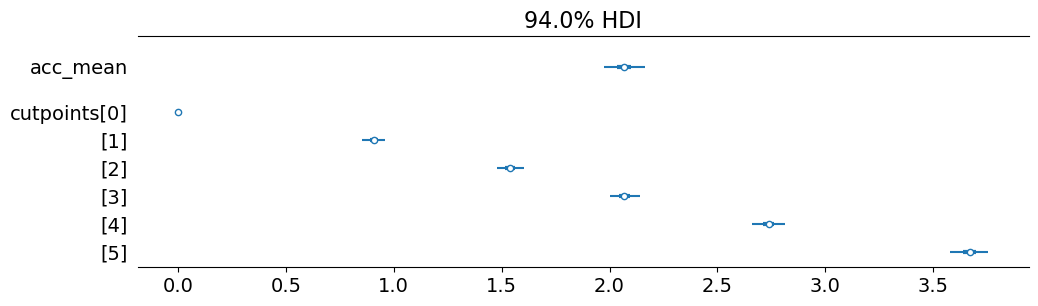

In [61]:
#| code-fold: true
#| code-summary: "Plotting code"

from arviz import plot_forest

_ = plot_forest(
    intercept_only_model_fit,
    var_names=["acc_mean", "cutpoints"],
    combined=True,
    figsize=(11.5, 3),
)

This slight right bias makes sense in light of the distribution of responses in the data.^[Note that this distribution is different from the one observed [here](model-definition#data-collection-instrument) because we are only fitting to the test items. The fillers are removed.]

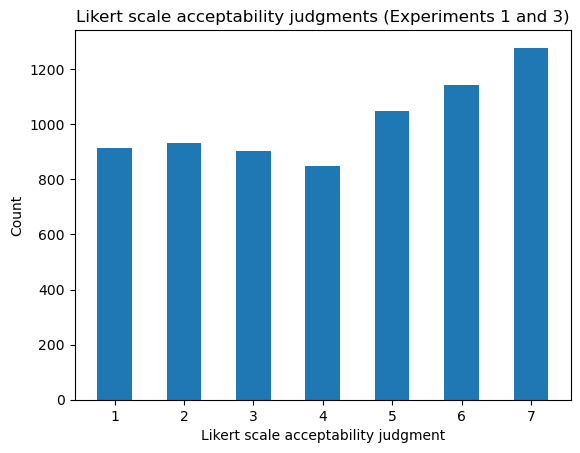

In [63]:
#| code-fold: true
#| code-summary: "Plotting code"

from numpy import arange
from matplotlib.pyplot import subplot


ax = subplot()
ax.hist(data_test.judgment, bins=arange(1, 9), rwidth=0.5, align="left")

ax.set_title("Likert scale acceptability judgments (Experiments 1 and 3)")
ax.set_xlabel("Likert scale acceptability judgment")
_ = ax.set_ylabel("Count")

If we look at the `jumps`, we note that there tends to be a preference for ordinal response levels that are nearer to the edges of the scale–with the bin size for 4 (`jumps[2]`) almost half the bin size of 2 (`jumps[0]`) and 6 (`jumps[4]`). The relative size of `subj_intercept_std` indicates that subjects can differ in their left- or right-bias by approximately an entire ordinal response level. 

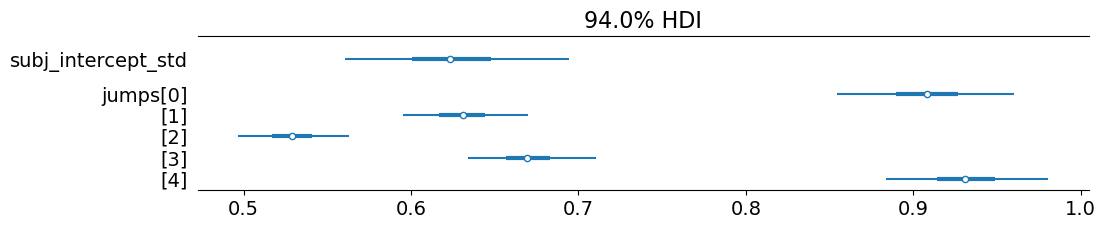

In [62]:
#| code-fold: true
#| code-summary: "Plotting code"

_ = plot_forest(
    intercept_only_model_fit,
    var_names=["subj_intercept_std", "jumps"],
    combined=True,
    figsize=(11.5, 2),
)

## Generalizing to other models

To faciliate code reuse, we'll develop an [abstract base class](https://docs.python.org/3/library/abc.html) (ABC) that defines our fitting procedure. The main things to focus on here are the `IslandEffectsModel.construct_model_data` and `IslandEffectsModel.fit` methods–the lattr of which is modeled on the [`sklearn`](https://scikit-learn.org/stable/) API.

In [9]:
#| source-line-numbers: "25-34,39-87"

import cmdstanpy
from abc import ABC
from typing import Optional
from dataclasses import dataclass
from numpy import ndarray
from cmdstanpy import CmdStanModel

@dataclass
class IslandEffectsData:
    N_resp: int            # number of responses
    N_subj: int            # number of subjects
    N_resp_levels: int     # number of possible likert scale acceptability judgment responses
    subj: ndarray          # subject who gave response n
    resp: ndarray          # likert scale acceptability judgment responses

class IslandEffectsModel(ABC):
    """An abstract base class for island effects models"""
    
    stan_file: str
    data_class = IslandEffectsData
    
    def __init__(self):
        self.model = CmdStanModel(stan_file=self.stan_file)
        
    def construct_model_data(self, data: DataFrame):
        subj_hash_map, subj_hashed = hash_series(data.subject)
    
        return {
            "N_resp": data.shape[0],
            "N_subj": subj_hash_map.shape[0],
            "N_resp_levels": 7,
            "subj": subj_hashed,
            "resp": data.judgment.astype(int).values
        }

    def _validate_data(self):
        self.data_class(**self.model_data)

    def fit(
        self, 
        data: DataFrame,
        save_dir: Optional[str] = None,
        verbose: bool = False,
        map_initialization: bool = True,
        seed: int = 50493,
        **kwargs
    ) -> InferenceData:
        if verbose:
            print("Constructing model data...")
            
        self.model_data = self.construct_model_data(data)
        
        self._validate_data()
        
        if map_initialization:
            if verbose:
                print("Fitting model with MAP initialization...")

            map_estimate = self._compute_map_estimate(seed)
            
            if "inits" in kwargs:
                # inits passed to fit() should override MAP
                map_estimate.update(kwargs["inits"])

            kwargs["inits"] = map_estimate
        
        elif verbose:
            print("Fitting model...")
        
        # sample from the posterior starting at the MAP
        self.raw_model_fit = self.model.sample(
            data=self.model_data,
            **kwargs
        )
    
        if save_dir is not None:
            if verbose:
                print("Saving model...")

            self.save(save_dir)
            
        if verbose:
            print("Running MCMC diagnostics...")
            print()
            print(self.diagnose())
    
        return self
    
    def _compute_map_estimate(self, seed: int):
        # compute MAP fit
        self.map_model_fit = self.model.optimize(
            data=self.model_data,
            seed=seed,
            algorithm="lbfgs",
            tol_obj=1.
        )

        return self.map_model_fit.stan_variables()
    
    @property
    def model_fit(self):
        return arviz.from_cmdstanpy(self.raw_model_fit)
    
    def save(self, save_dir: str = "."):
        self.raw_model_fit.save_csvfiles(save_dir)
    
    @classmethod
    def from_csv(cls, path: str, **kwargs):
        model = cls(**kwargs)
        model.raw_model_fit = cmdstanpy.from_csv(path)
        
    def diagnose(self):
        return self.raw_model_fit.diagnose()

It is then straightforward to simply specify the STAN model file as a class attribute of some subclass of this ABC.

In [10]:
class InterceptOnlyModel(IslandEffectsModel):
    stan_file = "models/intercept-only-model/intercept-only-model.stan"

In [ ]:
intercept_only_model = InterceptOnlyModel()
intercept_only_model.fit(data_test)

We can similarly specify and fit our item random effects model by (i) specifying the appropriate STAN file; and (ii) adding item information to the model's data representation.

In [12]:
@dataclass
class ItemRandomEffectsData(IslandEffectsData):
    N_item: int              # number of items
    item: ndarray            # item corresponding to response n

class ItemRandomEffectsModel(InterceptOnlyModel):
    stan_file = "models/item-random-effects-model/item-random-effects-model.stan"
    data_class = ItemRandomEffectsData
    
    def construct_model_data(self, data: DataFrame):
        model_data = super().construct_model_data(data)
    
        self.item_hash_map, item_hashed = hash_series(data.item)

        model_data.update({
            "N_item": self.item_hash_map.shape[0],
            "item": item_hashed
        })
        
        return model_data

In [ ]:
item_random_effects_model = ItemRandomEffectsModel()
item_random_effects_model.fit(data_test)

This model yields a similar posterior for `acc_mean` and `cutpoints`–though the posterior of `acc_mean` has higher variance.

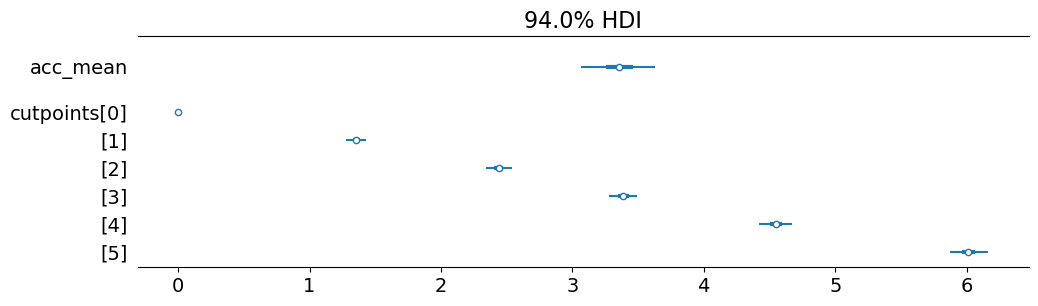

In [137]:
#| code-fold: true
#| code-summary: "Plotting code"

_ = plot_forest(
    item_random_effects_model.model_fit,
    var_names=["acc_mean", "cutpoints"],
    combined=True,
    figsize=(11.5, 3),
)

It also yields a similar posterior distribution for `subj_intercept_std` and `jumps`. As we would expect, since it is the only way that differences among items can be explained, `item_intercept_std` is substantially larger than `subj_intercept_std`.

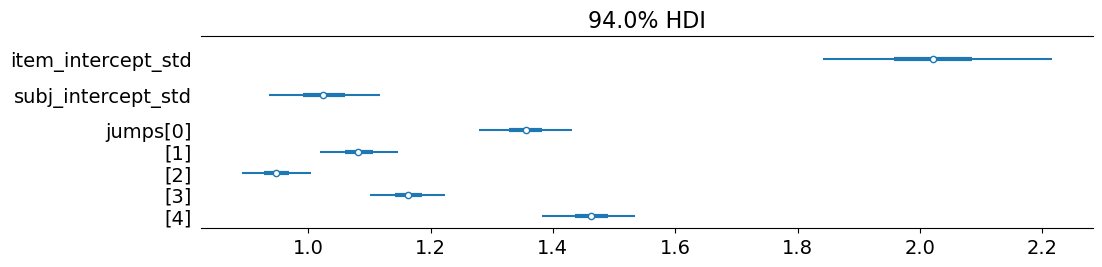

In [138]:
#| code-fold: true
#| code-summary: "Plotting code"

_ = plot_forest(
    item_random_effects_model.model_fit,
    var_names=["item_intercept_std", "subj_intercept_std", "jumps"],
    combined=True,
    figsize=(11.5, 2.5),
)

If we compare these two models using PSIS-LOO–measured in terms of *expected log-pointwise density* (ELPD)–we observe that (unsurprisingly) the item random effects model fits the data substantially better. This can be seen by the fact that its ELPD is substantially higher.

In [ ]:
from arviz import compare

compare_dict = {
    "Intercept-only model": intercept_only_model.model_fit, 
    "Item random effects model": item_random_effects_model.model_fit
}

model_comparison = compare(compare_dict)

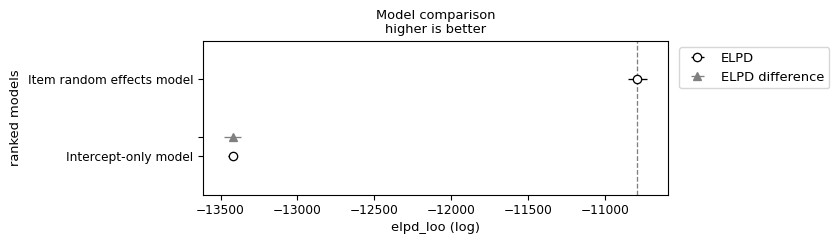

In [65]:
#| code-fold: true
#| code-summary: "Plotting code"

from arviz import plot_compare

_ = plot_compare(model_comparison)

If we look at the item random intercept model's $p_\text{loo}$, which is the measure of model complexity, we also see that it is substantially higher. But because the fit is so much better, when we combine $p_\text{loo}$ with the likelihood to derive ELPD$_\text{loo}$, the model is still preferred.

In [69]:
model_comparison[["elpd_loo", "p_loo", "se", "elpd_diff", "dse"]]

,elpd_loo,p_loo,se,elpd_diff,dse
Item random effects model,-10793.713336,568.829390,61.709994,0.000000,0.00000
Intercept-only model,-13420.902081,273.016164,29.042153,2627.188745,57.07066


As we move forward, we will be particularly interested in `elpd_diff` and `dse`. `elpd_diff` tells us how much better the best model family in terms of PSIS-LOO is, and `dse` tells us the standard error of that difference. One important thing to note is that we can also compute a standard error of ELPD$_\text{loo}$ itself (`se` above), but `dse` is note computable from this quantity, since `dse` is computed pointwise.^[A good analogy here is between an unpaired $t$-test and a paired $t$-test.]

### Mixed effects models

To implement our three vanilla mixed effects models–the *no interaction model*, *minimal interaction model*, and *maximal interaction model*–we will develop an generalization of the ABC that accepts formulae for the fixed effects, by-item effect, and by-subject effects.

In [17]:
@dataclass
class MixedEffectsData(IslandEffectsData):
    N_fixed: int                 # number of fixed predictors
    fixed_predictors: ndarray    # predictors (length and dependency type) including intercept
    N_item: int                  # number of items
    N_by_item: int               # number of random by-item predictors
    by_item_predictors: ndarray  # by-item predictors (length and dependency type) including intercept
    N_by_subj: int               # number of random by-subject predictors
    by_subj_predictors: ndarray  # by-subject predictors (length and dependency type) including intercept
    item: ndarray                # item corresponding to response n

In [18]:
import patsy
from numpy import array

class MixedEffectsModel(IslandEffectsModel):
    stan_file = "models/mixed-effects-model/mixed-effects-model.stan"
    data_class = MixedEffectsData
    
    def __init__(
        self, fixed_formula: str, by_subj_formula: str, by_item_formula: str, 
    ):
        super().__init__()
        
        self.fixed_formula = fixed_formula
        self.by_subj_formula = by_subj_formula
        self.by_item_formula = by_item_formula
    
    def construct_model_data(self, data: DataFrame):
        model_data = super().construct_model_data(data)

        self.fixed_predictors = patsy.dmatrix(
            self.fixed_formula, data, return_type="dataframe"
        )
        
        self.by_subj_predictors = patsy.dmatrix(
            self.by_subj_formula, data, return_type="dataframe"
        )
        
        self.by_item_predictors = patsy.dmatrix(
            self.by_item_formula, data, return_type="dataframe"
        )
        
        self.item_hash_map, item_hashed = hash_series(data.item)
        
        model_data.update({
            "N_fixed": self.fixed_predictors.shape[1],
            "fixed_predictors": self.fixed_predictors.values,
            "N_by_subj": self.by_subj_predictors.shape[1],
            "by_subj_predictors": self.by_subj_predictors.values,
            "N_item": self.item_hash_map.shape[0],
            "N_by_item": self.by_item_predictors.shape[1],
            "by_item_predictors": self.by_item_predictors.values,
            "item": item_hashed
        })
        
        return model_data
    
    def _compute_map_estimate(self, seed:int):
        map_estimate = super()._compute_map_estimate(seed)
        
        for vname, v in map_estimate.items():
            if "cov" in vname and not hasattr(v, "shape"):
                map_estimate[vname] = array([[v]])
                
        return map_estimate

We can then fit the three models by specifying [the formulae from the last section](model-definition#adding-grammar-and-processing-effects).

In [ ]:
distance_levels = ["short", "long"]
structure_levels = ["non", "island"]
dependency_levels = ["WH", "RC", "DlinkedWH", "DlinkedRC"]
island_levels = ["WH", "SUB", "ADJ", "NP"]

distance_term = "C(distance, levels=distance_levels)"
structure_term = "C(structure, levels=structure_levels)"
island_term = "C(island, levels=island_levels)"
dependency_term = "C(dependency, levels=dependency_levels)"

no_interaction_model = MixedEffectsModel(
    fixed_formula=f"~ ({distance_term} + {structure_term}) * {island_term} * {dependency_term}",
    by_subj_formula=f"~ 1",
    by_item_formula="~ 1",
)

no_interaction_model.fit(data_test)

In [ ]:
twoway_interaction_model = MixedEffectsModel(
    fixed_formula=no_interaction_model.fixed_formula + f"+ {distance_term} * {structure_term}",
    by_subj_formula=no_interaction_model.by_subj_formula,
    by_item_formula="~ 1",
)

twoway_interaction_model.fit(data_test)

In [ ]:
full_interaction_model = MixedEffectsModel(
    fixed_formula=f"~ {distance_term} * {structure_term} * {island_term} * {dependency_term}",
    by_subj_formula=no_interaction_model.by_subj_formula,
    by_item_formula="~ 1",
)

full_interaction_model.fit(data_test)

### Clustered mixed effects models

To implement the clustered mixed effects models, we need to add a way of specifying which interactions we would like to model as discrete. We'll enforce that, if an item does not instantiate `distance`=`long` and `island`=`island`, it gets mapped to `no_interaction`.

In [27]:
@dataclass
class ClusteredMixedEffectsData(MixedEffectsData):
    N_grammaticality_levels: int          # number of grammaticality levels
    N_interactions: int                   # number of interactions to model as discrete
    interactions: ndarray                 # interactions to model as discrete 

class ClusteredMixedEffectsModel(MixedEffectsModel):
    data_class = ClusteredMixedEffectsData
    
    def __init__(self, n_grammaticality_levels: int, **kwargs):
        super().__init__(**kwargs)
        
        self.n_grammaticality_levels = n_grammaticality_levels
    
    def construct_model_data(self, data: DataFrame):
        model_data = super().construct_model_data(data)
        
        self.interactions_hash, interactions = hash_series(
            data[["distance", "structure", "island", "dependency"]].apply(
                lambda x: x[2] + "_" + x[3] if x[0] == "long" and x[1] == "island" else "no_interaction",
                axis=1
            )
        )
        
        model_data.update({
            "N_grammaticality_levels": self.n_grammaticality_levels,
            "N_interactions": self.interactions_hash.shape[0],
            "interactions": interactions
        })
        
        return model_data
    
class ConstrainedClusteredMixedEffectsModel(ClusteredMixedEffectsModel):
    stan_file = "models/constrained-clustered-interaction-model/constrained-clustered-interaction-model.stan"
    
class UnconstrainedClusteredMixedEffectsModel(ClusteredMixedEffectsModel):
    stan_file = "models/unconstrained-clustered-interaction-model/unconstrained-clustered-interaction-model.stan"
    
    def _compute_map_estimate(self, seed:int):
        map_estimate = super()._compute_map_estimate(seed)
        
        for vname, v in map_estimate.items():
            if "penalty" in vname and not hasattr(v, "shape"):
                map_estimate[vname] = array([v])
                
        return map_estimate

We will consider models with 2, 3, and 4 levels of grammaticality.

In [ ]:
discrete_models = {}
continuous_models = {}

for g in range(2, 5):
    print(f"Fitting discrete model with {g} grammaticality levels...")
    
    constrained_models[g] = ConstrainedClusteredMixedEffectsModel(
        n_grammaticality_levels=g,
        fixed_formula=no_interaction_model.fixed_formula,
        by_subj_formula=no_interaction_model.by_subj_formula,
        by_item_formula="~ 1",
    )
    
    constrained_models[g].fit(data_test)
    
    print(f"Fitting continuous model with {g} grammaticality levels...")
    
    unconstrained_models[g] = UnconstrainedClusteredMixedEffectsModel(
        n_grammaticality_levels=g,
        fixed_formula=no_interaction_model.fixed_formula,
        by_subj_formula=no_interaction_model.by_subj_formula,
        by_item_formula="~ 1",
    )
    
    unconstrained_models[g].fit(data_test)

## Model comparison

Finally, we will compute the model comparison using PSIS-LOO. These models are ranked by ELPD$_\text{loo}$.

In [73]:
compare_dict = {
    "No interaction model": no_interaction_model.model_fit,
    "Minimal interaction model": twoway_interaction_model.model_fit,
    "Maximal interaction model": full_interaction_model.model_fit
}

for n_grammaticality_levels, m in constrained_models.items():
    name = f"Constrained model ({n_grammaticality_levels} levels)"
    compare_dict[name] = m.model_fit
    
for n_grammaticality_levels, m in unconstrained_models.items():
    name = f"Unconstrained model ({n_grammaticality_levels} levels)"
    compare_dict[name] = m.model_fit

model_comparison = compare(compare_dict)

model_comparison[["elpd_loo", "p_loo", "elpd_diff", "dse"]]

,elpd_loo,p_loo,elpd_diff,dse
Constrained model (4 levels),-10716.830739,566.988072,0.000000,0.000000
Unconstrained model (4 levels),-10717.042327,567.278971,0.211588,0.629807
Constrained model (3 levels),-10718.938079,569.969504,2.107341,0.684705
Unconstrained model (3 levels),-10719.299001,569.839128,2.468262,0.880495
Constrained model (2 levels),-10719.712935,567.872110,2.882196,1.703436
Minimal interaction model,-10721.546329,565.649372,4.715591,2.948452
Unconstrained model (2 levels),-10721.878888,569.544818,5.048149,1.610423
Maximal interaction model,-10721.923465,574.947989,5.092726,1.902887
No interaction model,-10725.226354,573.342717,8.395615,4.284287


There are a few things to note about this comparison. 

First, all models that have grammatical effects dominate the no interaction model. This ranking is not surprising, given the difference of differences we saw in the last section, but it is a good sanity check.

Second, the minimal and maximal interaction models have effectively the same ELPD$_\text{loo}$, even though the $p_\text{loo}$ for the maximal interaction model is nearly 10 points higher. This pattern indicates that the maximal interaction model fits better than the minimal interaction model–as we would expect–but when trading complexity off with fit, there is not reason to prefer the better-fitting maximal interaction model to the worse-fitting minimal interaction model (or vice versa).

Finally, nearly all the clustered mixed effects models dominate the minimal and maximal interaction models, with more levels (at least up to 4) improving the PSIS-LOO. This result, which is driven by improved fit without a substantial increase in complexity as evidenced by the $p_\text{loo}$s, is promising for the clustered mixed effects models. We need to be cautious in interpreting this ranking, however, since the ratio of difference in ELPD to `dse`–especially in for the minimal interaction model–is small and these comparisons are being conducted *post hoc*. Ideally, to confirm this ranking, we would collect a new sample that would likely need to be quite a bit larger than the one collected by @sprouse_experimental_2016.

## Digging into the clustered mixed effects models

One useful aspect of the clustered mixed effects models is that they allow us to dig into (i) the penalty along the acceptability continuum associated with ungrammaticality; and (ii) which level of grammaticality would be associated with a particular structure using the membership probabilities.

### Grammaticality penalties

The penalty of each level of ungrammaticality in the constrained model is approximately -0.75.

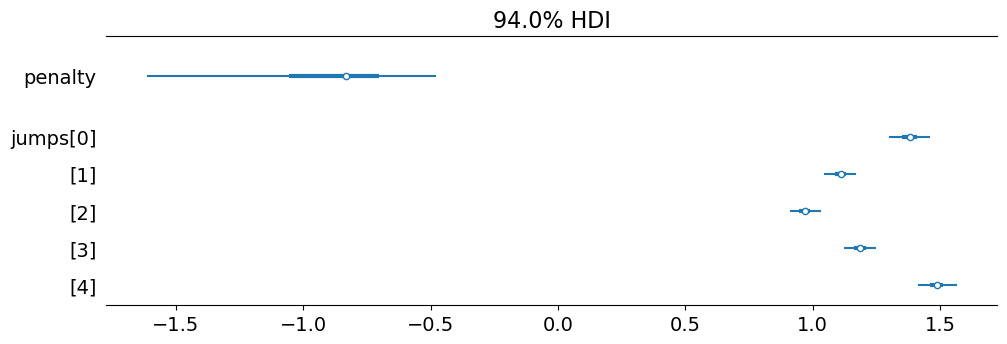

In [94]:
#| code-fold: true
#| code-summary: "Plotting code"

_ = plot_forest(
    constrained_models[4].model_fit,
    var_names=["penalty", "jumps"],
    combined=True,
    figsize=(11.5, 3.5),
)

For comparison, the effects of `distance`=`long` and `structure`=`island` are each about -1.5. So the effect of one increment of ungrammaticality is about half that of the effects of `distance`=`long` and `structure`=`island`. 

In [158]:
import re
from arviz import summary

def format_factor_levels(x):
    extracted = re.findall("C\(([A-z]+).+?\)\[T\.([A-z]+)\]", x)
    return ' x '.join([f"{k}={v}" for k, v in extracted])

constrained_coefs = summary(constrained_models[4].model_fit, "fixed_coefs")

constrained_coefs.index = constrained_models[4].fixed_predictors.columns.map(format_factor_levels)

constrained_coefs[["mean", "sd", "hdi_3%", "hdi_97%"]]

,mean,sd,hdi_3%,hdi_97%
,6.935,0.365,6.270,7.634
distance=long,-1.606,0.426,-2.359,-0.784
structure=island,-1.407,0.437,-2.210,-0.588
island=SUB,-2.188,0.466,-3.091,-1.328
island=ADJ,-1.783,0.446,-2.629,-0.973
island=NP,-0.181,0.468,-0.981,0.740
dependency=RC,-3.002,0.467,-3.894,-2.119
dependency=DlinkedWH,-0.993,0.328,-1.606,-0.372
dependency=DlinkedRC,-2.717,0.475,-3.651,-1.881
distance=long x island=SUB,2.820,0.559,1.720,3.854


In contrast, the penalty for the first level of ungrammaticality in the unconstrained model is a bit over -1 with the remaining penalties being a bit stronger than -0.5.

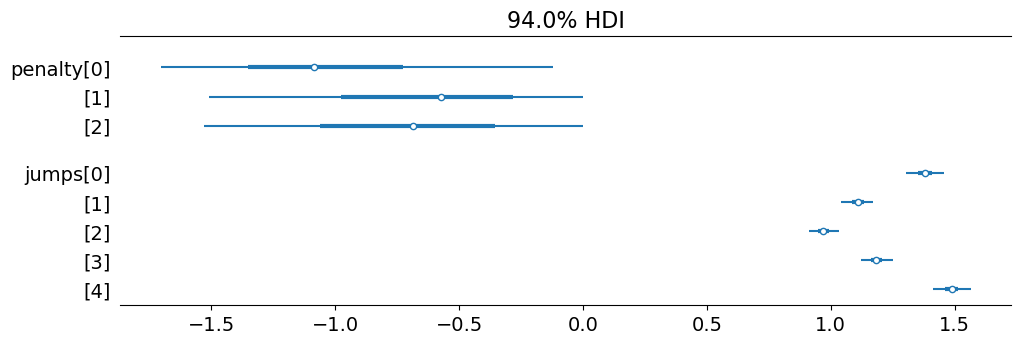

In [95]:
#| code-fold: true
#| code-summary: "Plotting code"

_ = plot_forest(
    unconstrained_models[4].model_fit,
    var_names=["penalty", "jumps"],
    combined=True,
    figsize=(11.5, 3.5),
)

And the pattern of fixed effects coefficients for the unconstrained model is very similr to that for the constrained model.

In [159]:
def format_factor_levels(x):
    extracted = re.findall("C\(([A-z]+).+?\)\[T\.([A-z]+)\]", x)
    return ' x '.join([f"{k}={v}" for k, v in extracted])

unconstrained_coefs = summary(unconstrained_models[4].model_fit, "fixed_coefs")

unconstrained_coefs.index = unconstrained_models[4].fixed_predictors.columns.map(format_factor_levels)

unconstrained_coefs[["mean", "sd", "hdi_3%", "hdi_97%"]]

,mean,sd,hdi_3%,hdi_97%
,7.024,0.467,6.161,7.821
distance=long,-1.613,0.421,-2.376,-0.795
structure=island,-1.446,0.429,-2.211,-0.576
island=SUB,-2.188,0.466,-3.069,-1.322
island=ADJ,-1.792,0.457,-2.624,-0.912
island=NP,-0.164,0.459,-1.063,0.682
dependency=RC,-3.018,0.456,-3.845,-2.166
dependency=DlinkedWH,-1.029,0.335,-1.640,-0.382
dependency=DlinkedRC,-2.744,0.461,-3.607,-1.865
distance=long x island=SUB,2.818,0.551,1.709,3.776


### Membership probabilities

Turning to the level of grammaticality associated with particular structures, in the constrained model, we see that the majority split between levels 1 and 2, with level 3 reserved for WH question formation out of an NP or WH island.

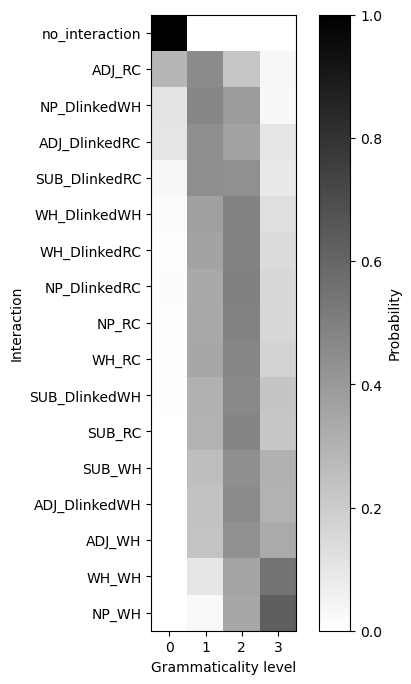

In [161]:
#| code-fold: true
#| code-summary: "Plotting code"

from numpy import exp, arange, argsort
from matplotlib.pyplot import subplots

log_membership_probs_constrained = constrained_models[4].raw_model_fit.stan_variable("log_membership")
membership_probs_constrained = exp(log_membership_probs_constrained).mean(0)

expected_membership_constrained = (membership_probs_constrained*arange(4)).mean(1)

sort_indices_constrained = argsort(expected_membership_constrained)

fig, ax = subplots(figsize=(6, 8))
img = ax.imshow(membership_probs_constrained[sort_indices_constrained])
ax.set_xticks(arange(4))
ax.set_xlabel("Grammaticality level")
ax.set_yticks(arange(17), discrete_models[4].interactions_hash[sort_indices])
ax.set_ylabel("Interaction")
img.set_cmap('binary')
_ = fig.colorbar(img, label="Probability")

We see a similar pattern in the unconstrained model.

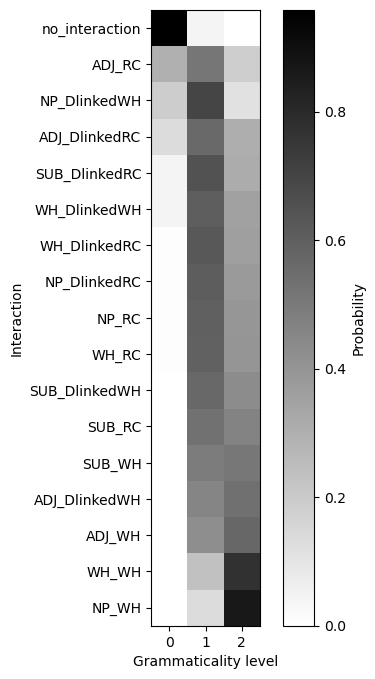

In [120]:
#| code-fold: true
#| code-summary: "Plotting code"

from numpy import exp, arange, argsort
from matplotlib.pyplot import subplots

log_membership_probs_unconstrained = unconstrained_models[3].raw_model_fit.stan_variable("log_membership")
membership_probs_unconstrained = exp(log_membership_probs_unconstrained).mean(0)

expected_membership_unconstrained = (membership_probs_unconstrained*arange(3)).mean(1)

sort_indices = argsort(expected_membership_unconstrained)

fig, ax = subplots(figsize=(6, 8))
img = ax.imshow(membership_probs_unconstrained[sort_indices])
ax.set_xticks(arange(3))
ax.set_xlabel("Grammaticality level")
ax.set_yticks(arange(17), unconstrained_models[3].interactions_hash[sort_indices])
ax.set_ylabel("Interaction")
img.set_cmap('binary')
_ = fig.colorbar(img, label="Probability")

Comparing the expected grammaticality level for each structure with the difference of differences we observed for that structure, we see a very tight correlation.

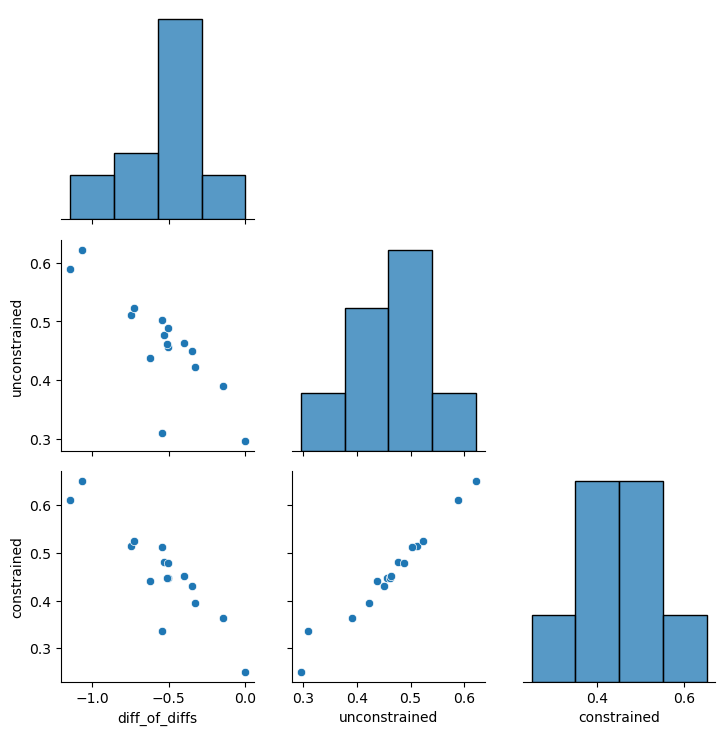

In [163]:
#| code-fold: true
#| code-summary: "Plotting code"

from pandas import merge
from seaborn import PairGrid, scatterplot, histplot

factors = [
    "island", "dependency",
    "distance", "structure" 
]

data_test_itemmeans = data_test.groupby(
    factors + ["item"]
)[["zscores"]].mean().reset_index()

data_test_itemmeans["itemnum"] = data_test_itemmeans.item.map(
    lambda x: x.split(".")[-1]
)

data_test_itemmeans_cast = data_test_itemmeans.pivot_table(
    index=["island", "dependency", "itemnum"], 
    columns=["distance", "structure"], 
    values="zscores"
)

short_diffs = data_test_itemmeans_cast.short.non -\
              data_test_itemmeans_cast.short.island
long_diffs = data_test_itemmeans_cast.long.non -\
             data_test_itemmeans_cast.long.island

diffs_of_diffs = (short_diffs - long_diffs).reset_index()

diffs_of_diffs["island_dependency"] = diffs_of_diffs.island + "_" + diffs_of_diffs.dependency

diffs_of_diffs = diffs_of_diffs.rename(columns={
    0: "diff_of_diffs"
})

diffs_of_diffs_mean = diffs_of_diffs.groupby("island_dependency")[["diff_of_diffs"]].mean()

expected_membership_constrained_df = DataFrame(
    expected_membership_constrained,
    index=constrained_models[3].interactions_hash,
    columns=["constrained"]
)

expected_membership_unconstrained_df = DataFrame(
    expected_membership_unconstrained,
    index=unconstrained_models[3].interactions_hash,
    columns=["unconstrained"]
)

diffs_of_diffs_expected_membership = merge(
    diffs_of_diffs_mean, 
    merge(
        expected_membership_unconstrained_df, 
        expected_membership_constrained_df, 
        left_index=True, right_index=True), 
    left_index=True, right_index=True
)

g = PairGrid(
    diffs_of_diffs_expected_membership,
    diag_sharey=False, corner=True
)

g.map_diag(histplot, bins=4)
_ = g.map_lower(scatterplot)

## Summing up

In this first module of the course, we focused on minimally extending standard statistical models used in analyzing acceptability judgments–[generalized linear](https://en.wikipedia.org/wiki/Generalized_linear_model) [mixed effects models](https://en.wikipedia.org/wiki/Mixed_model)–in order to probe the nature of the grammatical representations that drive acceptability judgments. We considered two possibilities discussed by @sprouse_acceptability_2018: (a) that the grammatical representations underlying acceptability judgments are *discrete* (or *categorical*); and (b) the grammatical representations are *continuous* (or *gradient*).

The basic recipe, which we will repeat through the course, was (i) to define two or more (families of) models–in this case, our not interaction, minimal interaction, maximal interaction, and clustered interaction models; (ii) to fit both models to the data from some acceptability judgment data–in this case, to the data collected by @sprouse_experimental_2016; and (iii) to compare how well the two models fit the data, weighed against some measure of how parsimonious (or conversely, complex) each model is using PSIS-LOO.

We saw that the models that inject additional discrete structure into the standard mixed effects models not only imrpove fit while keeping complexity at bay, they are also quite interpretable. In the next module, we will look at a similar approach to modeling inference judgment data.